In [36]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

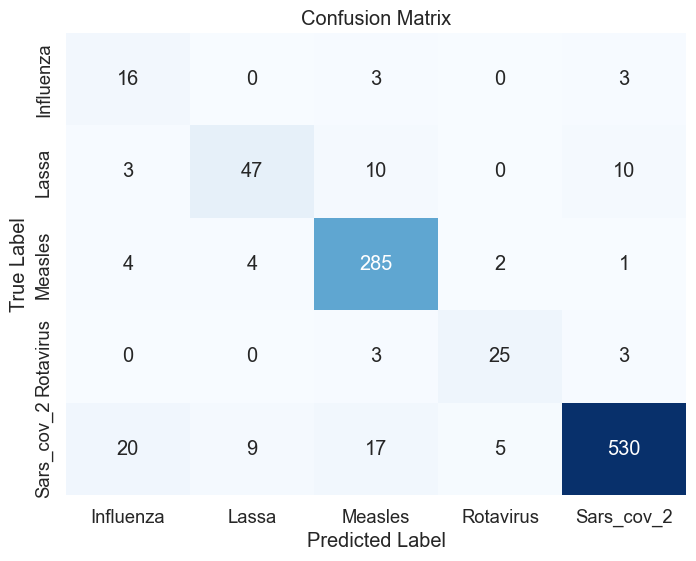

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Replace the values below with your actual confusion matrix
confusion_matrix = np.array([[16, 0, 3, 0, 3],
                             [3, 47, 10, 0, 10],
                             [4, 4, 285, 2, 1],
                             [0, 0, 3, 25, 3],
                             [20, 9, 17, 5, 530]])

# Define class labels
class_labels = ["Influenza", "Lassa", "Measles", "Rotavirus", "Sars_cov_2"]
  
# Create a heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [38]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

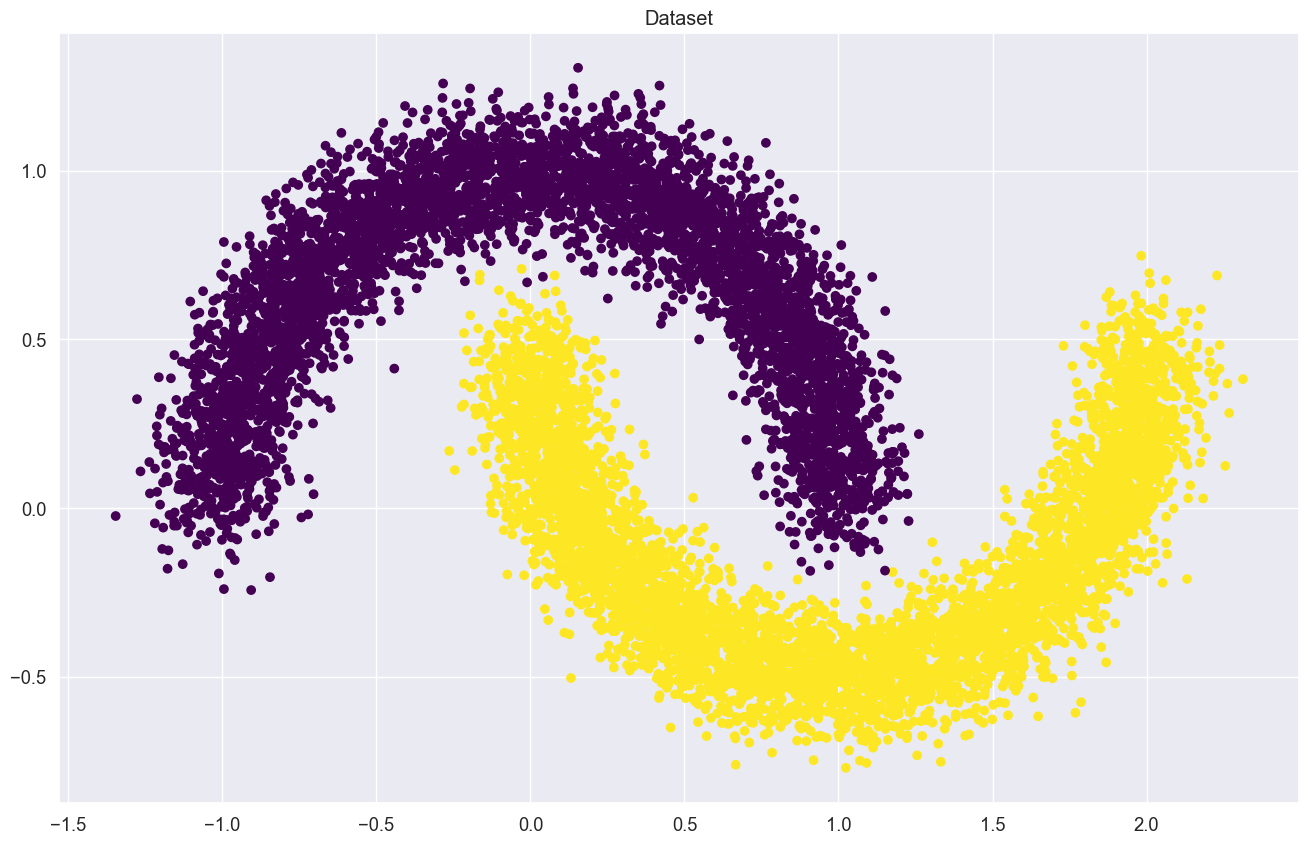

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [41]:
# Convert NumPy arrays to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`.

In [42]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [43]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = torch.matmul(x, self.weights.t())  # XW (matrix multiplication)
        if self.bias:
            x += self.bias_term
        return x

In [44]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [45]:
for name, param in linear_regression.named_parameters():
    print(f"Parameter name: {name}, Size: {param.size()}")

Parameter name: weights, Size: torch.Size([1, 2])
Parameter name: bias_term, Size: torch.Size([1])


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [46]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.flatten(), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = F.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.234375


Iteration: 100
Batch accuracy: 0.5390625
Iteration: 200
Batch accuracy: 0.7734375
Iteration: 300
Batch accuracy: 0.828125
Iteration: 400
Batch accuracy: 0.8125
Iteration: 500
Batch accuracy: 0.8671875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.796875
Iteration: 800
Batch accuracy: 0.8125
Iteration: 900
Batch accuracy: 0.8203125

Iteration: 932.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

### Визуализируем результаты

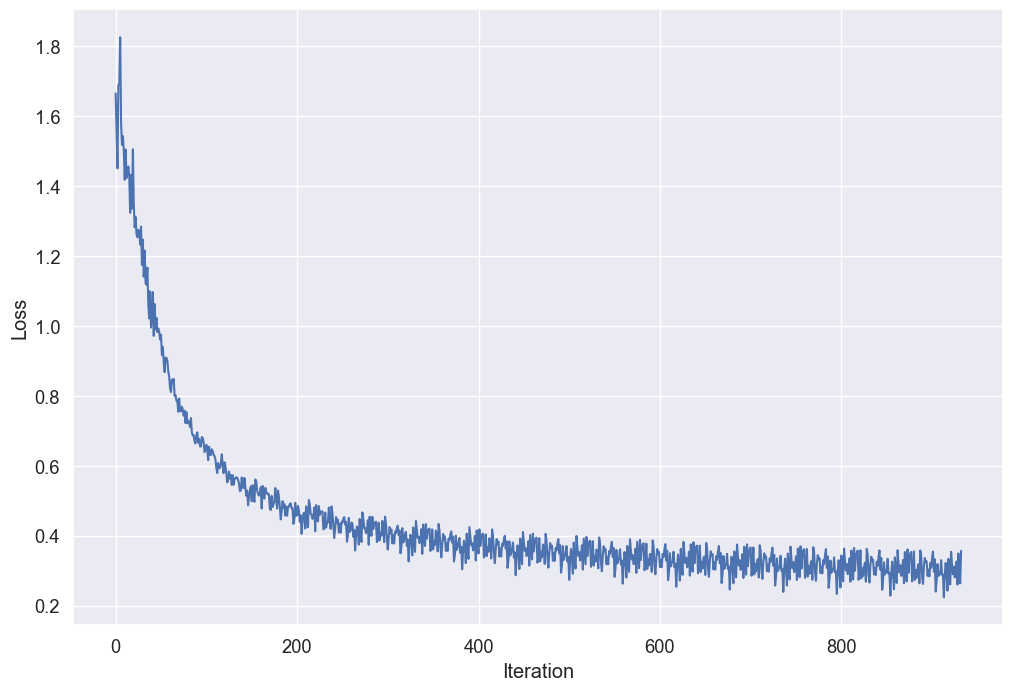

In [47]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

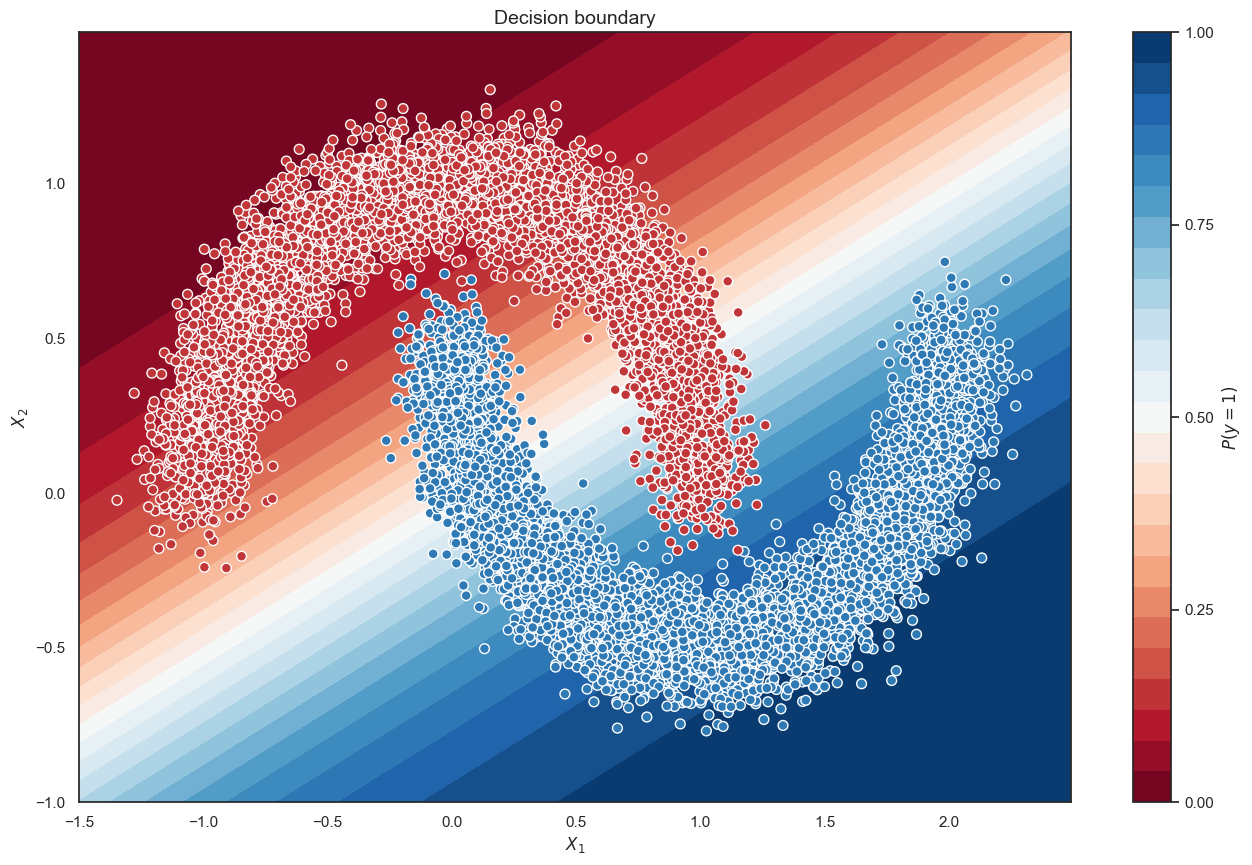

In [48]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [49]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    true_labels_list = np.array([])
    for x_batch, true_labels_batch in dataloader:
        outp = model(x_batch)
        preds = (torch.sigmoid(outp) > 0.5).type(torch.int)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        true_labels_list = np.hstack((true_labels_list, true_labels_batch.numpy().flatten()))
    return predictions.flatten(), true_labels_list.flatten()


In [50]:
from sklearn.metrics import accuracy_score
predictions, true_labels = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(true_labels, predictions)
print(f'Total Accuracy: {accuracy * 100:.2f}%')


Total Accuracy: 86.04%


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 86.20%

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [51]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128  # Choose an appropriate batch size

# DataLoader for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [87]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [53]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),  # Input size is 28*28 for MNIST images
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)  # Output layer with 10 neurons for 10 classes
)


In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [56]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8893333333333333
Loader: valid. Accuracy: 0.9369
Epoch: 2
Loader: train. Accuracy: 0.95065
Loader: valid. Accuracy: 0.9619
Epoch: 3
Loader: train. Accuracy: 0.9631833333333333
Loader: valid. Accuracy: 0.9662
Epoch: 4
Loader: train. Accuracy: 0.9719166666666667
Loader: valid. Accuracy: 0.9708
Epoch: 5
Loader: train. Accuracy: 0.9757666666666667
Loader: valid. Accuracy: 0.9773
Epoch: 6
Loader: train. Accuracy: 0.97945
Loader: valid. Accuracy: 0.9708
Epoch: 7
Loader: train. Accuracy: 0.9824
Loader: valid. Accuracy: 0.9756
Epoch: 8
Loader: train. Accuracy: 0.9843166666666666
Loader: valid. Accuracy: 0.9757
Epoch: 9
Loader: train. Accuracy: 0.9848666666666667
Loader: valid. Accuracy: 0.971
Epoch: 10
Loader: train. Accuracy: 0.98705
Loader: valid. Accuracy: 0.9795


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [88]:
import torch.nn.functional as F

def test_activation_function(activation, loaders):
    activation = activation

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),  # Input size is 28*28 for MNIST images
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)  # Output layer with 10 neurons for 10 classes
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    accuracy = {"train": [], "valid": []}
    print(activation)
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum().item()
                all_samples = y_batch.size(0)

                epoch_correct += correct
                epoch_all += all_samples

            accuracy[k].append(epoch_correct / epoch_all)
            print(f"Epoch: {epoch+1}, Loader: {k}. Accuracy: {epoch_correct/epoch_all:.4f}")

    return accuracy["valid"]


In [92]:
# Test different activation functions
plain_accuracy = test_activation_function(Identical(), loaders)
elu_accuracy = test_activation_function(nn.ELU(), loaders)
relu_accuracy = test_activation_function(nn.ReLU(), loaders)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(), loaders)

print("Plain Accuracy:", plain_accuracy[-1])
print("ELU Accuracy:", elu_accuracy[-1])
print("ReLU Accuracy:", relu_accuracy[-1])
print("Leaky ReLU Accuracy:", leaky_relu_accuracy[-1])

Identical()
Epoch: 1, Loader: train. Accuracy: 0.8724
Epoch: 1, Loader: valid. Accuracy: 0.9120
Epoch: 2, Loader: train. Accuracy: 0.9039
Epoch: 2, Loader: valid. Accuracy: 0.9142
Epoch: 3, Loader: train. Accuracy: 0.9070
Epoch: 3, Loader: valid. Accuracy: 0.9069
Epoch: 4, Loader: train. Accuracy: 0.9097
Epoch: 4, Loader: valid. Accuracy: 0.9117
Epoch: 5, Loader: train. Accuracy: 0.9123
Epoch: 5, Loader: valid. Accuracy: 0.9142
Epoch: 6, Loader: train. Accuracy: 0.9121
Epoch: 6, Loader: valid. Accuracy: 0.9134
Epoch: 7, Loader: train. Accuracy: 0.9138
Epoch: 7, Loader: valid. Accuracy: 0.9143
Epoch: 8, Loader: train. Accuracy: 0.9143
Epoch: 8, Loader: valid. Accuracy: 0.9119
Epoch: 9, Loader: train. Accuracy: 0.9149
Epoch: 9, Loader: valid. Accuracy: 0.9188
Epoch: 10, Loader: train. Accuracy: 0.9166
Epoch: 10, Loader: valid. Accuracy: 0.9130
ELU(alpha=1.0)
Epoch: 1, Loader: train. Accuracy: 0.8880
Epoch: 1, Loader: valid. Accuracy: 0.9431
Epoch: 2, Loader: train. Accuracy: 0.9486
Epoch

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

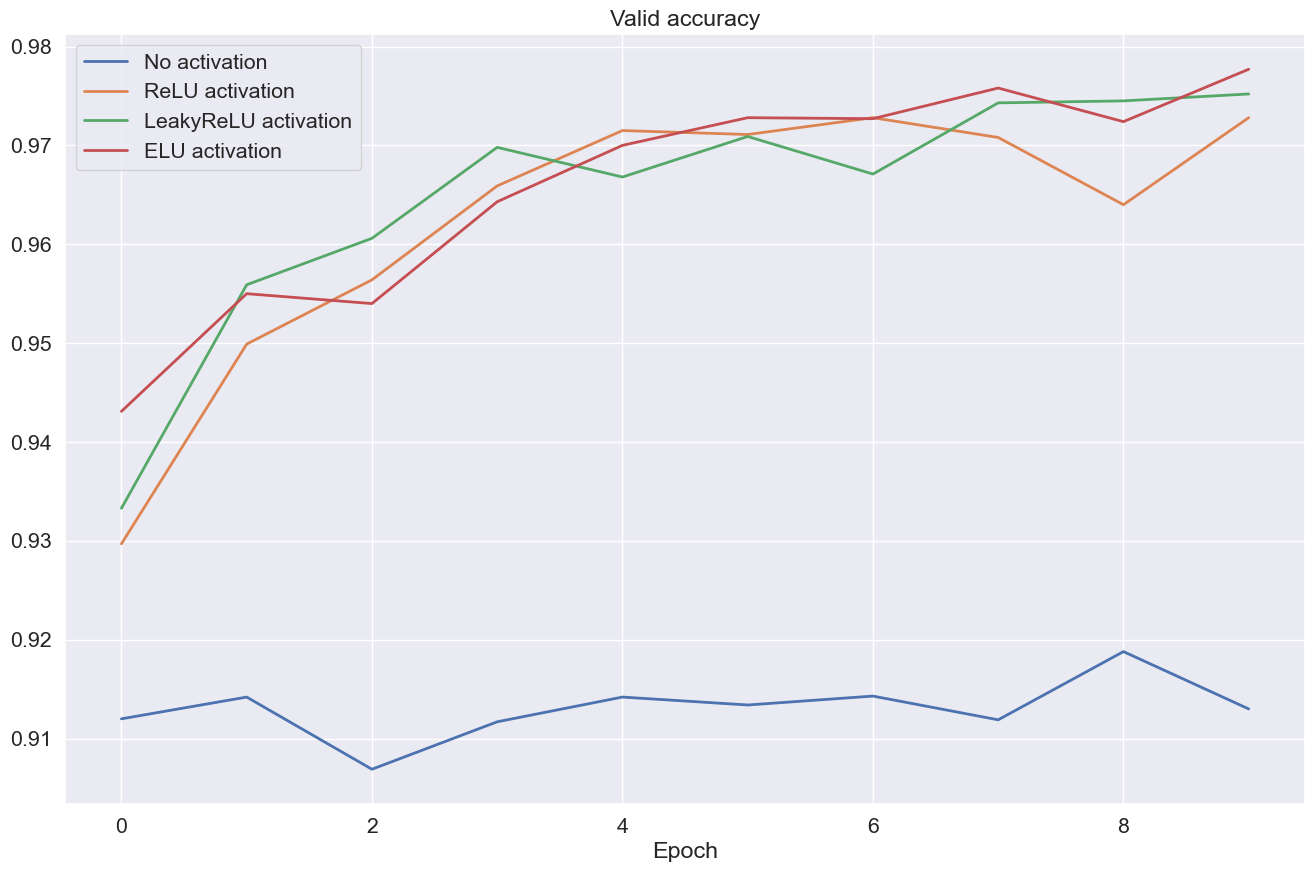

In [93]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

In [61]:

print("Plain Accuracy:", plain_accuracy[-1])
print("ELU Accuracy:", elu_accuracy[-1])
print("ReLU Accuracy:", relu_accuracy[-1])
print("Leaky ReLU Accuracy:", leaky_relu_accuracy[-1])

Plain Accuracy: 0.9742
ELU Accuracy: 0.9783
ReLU Accuracy: 0.981
Leaky ReLU Accuracy: 0.9812


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

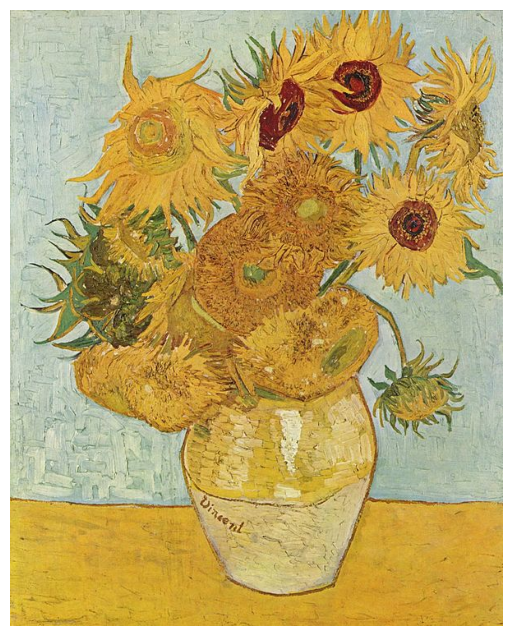

In [62]:
import requests
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
# URL of the image you want to download
image_url = "https://dovidka.biz.ua/wp-content/uploads/2016/11/SONYASHNIKI-VAN-GOG.jpg"

# Download the image
response = requests.get(image_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Open the image using OpenCV
    img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    # Convert BGR to RGB
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(RGB_img)
    plt.axis('off')  # Turn off axis labels
    plt.show()
else:
    print(f"Failed to download the image. Status code: {response.status_code}")


Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [63]:
import torch

img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


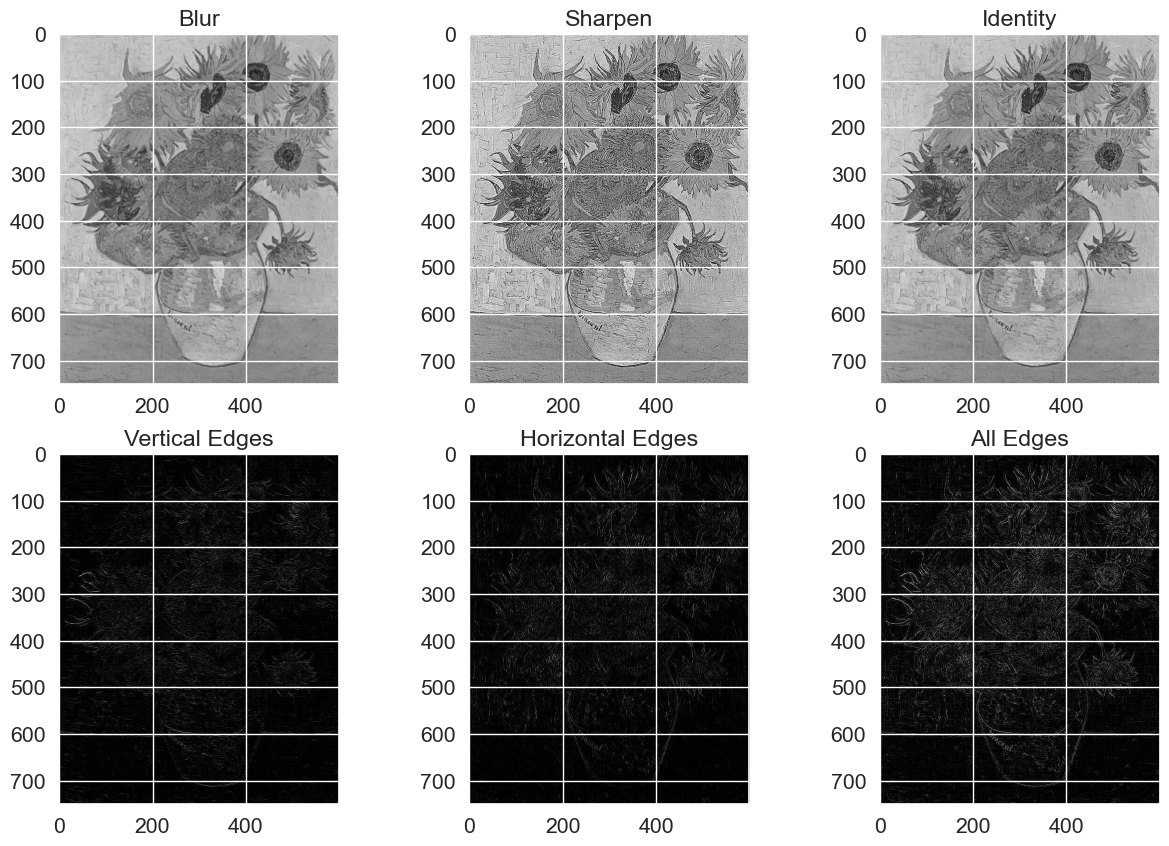

In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def apply_filter(img, kernel):
    img_t = torch.from_numpy(img).type(torch.float32).unsqueeze(0)
    kernel_t = torch.tensor(kernel).reshape(1, 1, 3, 3).type(torch.float32)
    kernel_t = kernel_t.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)
    img_t = torch.nn.ReflectionPad2d(1)(img_t)

    result = F.conv2d(img_t, kernel_t)[0]

    return result.permute(1, 2, 0).numpy() / 256 / 3

def apply_filters(img, filters, filter_labels):
    results = []
    for kernel, label in zip(filters, filter_labels):
        result = apply_filter(img, kernel)
        results.append((result, label))
    return results

# Example usage:

# List of filters and their labels
filters = [
    [[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]],  # Blur
    [[0, -1, 0], [-1, 5, -1], [0, -1, 0]],  # Sharpen
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]],  # Identity
    [[0, 1, 0], [0, -2, 0], [0, 1, 0]],  # Vertical Edges
    [[0, 0, 0], [1, -2, 1], [0, 0, 0]],  # Horizontal Edges
    [[0, 1, 0], [1, -4, 1], [0, 1, 0]]  # All Edges
]

filter_labels = [
    'Blur',
    'Sharpen',
    'Identity',
    'Vertical Edges',
    'Horizontal Edges',
    'All Edges'
]

# Apply filters using a loop
results = apply_filters(RGB_img, filters, filter_labels)

# Display results
plt.figure(figsize=(15, 10))

for i, (result, label) in enumerate(results, start=1):
    plt.subplot(2, 3, i)
    plt.imshow(result)
    plt.title(label)

plt.show()


**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

Вот соответствие названий и матриц:

1) **Размытие**
     ```
     [0.0625, 0.125, 0.0625]
     [0.125, 0.25, 0.125]
     [0.0625, 0.125, 0.0625]
     ```
   Объяснение: Эта матрица представляет собой усредняющий фильтр, который размывает изображение. Все значения матрицы равны, и применение её к изображению дает эффект размытия.

2) **Увеличение резкости**
     ```
     [0, -1, 0]
     [-1, 5, -1]
     [0, -1, 0]
     ```
   Объяснение: Эта матрица усиливает различия между соседними пикселями. Значение 5 в центре делает пиксель в центре вкладывающимся в исходный пиксель сильнее, чем соседние пиксели, что увеличивает резкость изображения.

3) **Тождественное преобразование**
     ```
     [0, 0, 0]
     [0, 1, 0]
     [0, 0, 0]
     ```
   Объяснение: Эта матрица является единичной матрицей, что означает, что она не вносит изменений в изображение. Применение такой матрицы к изображению приведет к тому, что изображение останется неизменным.

4) **Выделение вертикальных границ**
     ```
     [0, 1, 0]
     [0, -2, 0]
     [0, 1, 0]
     ```
   Объяснение: Эта матрица подчеркивает различия в интенсивности между пикселями в вертикальном направлении. Она обнаруживает вертикальные границы в изображении.

5) **Выделение горизонтальных границ**
     ```
     [0, 0, 0]
     [1, -2, 1]
     [0, 0, 0]
     ```
   Объяснение: Эта матрица подчеркивает различия в интенсивности между пикселями в горизонтальном направлении. Она обнаруживает горизонтальные границы в изображении.

6) **Выделение границ**
     ```
     [0, 1, 0]
     [1, -4, 1]
     [0, 1, 0]
     ```
   Объяснение: Эта матрица усиливает различия в интенсивности как в вертикальном, так и в горизонтальном направлении. Она может использоваться для обнаружения границ в обоих направлениях.

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [75]:
class LeNet(nn.Module):
    def __init__(self, activation):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        # 6 input channels, 16 output channels, 3x3 square conv kernel
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.activation = activation

    def forward(self, x):
        # Apply layers created in __init__
        x = self.activation(self.conv1(x))
        x = self.pool1(x)
        x = self.activation(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flatten the feature maps
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [82]:
def test_activation_function(activation, model, loaders):
    model = model
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    accuracy = {"train": [], "valid": []}
    print(activation)
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum().item()
                all_samples = y_batch.size(0)

                epoch_correct += correct
                epoch_all += all_samples

            accuracy[k].append(epoch_correct / epoch_all)
            print(f"Epoch: {epoch+1}, Loader: {k}. Accuracy: {epoch_correct/epoch_all:.4f}")

    return accuracy["valid"]


In [83]:
# Test different activation functions
#plain_accuracy_LeNet = test_activation_function(LeNet(Identical).to(device), loaders)
elu_accuracy_LeNet = test_activation_function(F.elu, LeNet(F.elu).to(device), loaders)
relu_accuracy_LeNet = test_activation_function(F.relu, LeNet(F.relu).to(device), loaders)
leaky_relu_accuracy_LeNet = test_activation_function(F.leaky_relu, LeNet(F.leaky_relu).to(device), loaders)

#print("Plain Accuracy:", plain_accuracy_LeNet[-1])
print("ELU Accuracy:", elu_accuracy_LeNet[-1])
print("ReLU Accuracy:", relu_accuracy_LeNet[-1])
print("Leaky ReLU Accuracy:", leaky_relu_accuracy_LeNet[-1])

<function elu at 0x000002DDABEA0900>
Epoch: 1, Loader: train. Accuracy: 0.9132
Epoch: 1, Loader: valid. Accuracy: 0.9744
Epoch: 2, Loader: train. Accuracy: 0.9765
Epoch: 2, Loader: valid. Accuracy: 0.9812
Epoch: 3, Loader: train. Accuracy: 0.9832
Epoch: 3, Loader: valid. Accuracy: 0.9839
Epoch: 4, Loader: train. Accuracy: 0.9874
Epoch: 4, Loader: valid. Accuracy: 0.9875
Epoch: 5, Loader: train. Accuracy: 0.9892
Epoch: 5, Loader: valid. Accuracy: 0.9875
Epoch: 6, Loader: train. Accuracy: 0.9912
Epoch: 6, Loader: valid. Accuracy: 0.9880
Epoch: 7, Loader: train. Accuracy: 0.9924
Epoch: 7, Loader: valid. Accuracy: 0.9886
Epoch: 8, Loader: train. Accuracy: 0.9936
Epoch: 8, Loader: valid. Accuracy: 0.9877
Epoch: 9, Loader: train. Accuracy: 0.9941
Epoch: 9, Loader: valid. Accuracy: 0.9880
Epoch: 10, Loader: train. Accuracy: 0.9953
Epoch: 10, Loader: valid. Accuracy: 0.9857
<function relu at 0x000002DDABEA0680>
Epoch: 1, Loader: train. Accuracy: 0.8989
Epoch: 1, Loader: valid. Accuracy: 0.9702

Сравним с предыдущем пунктом

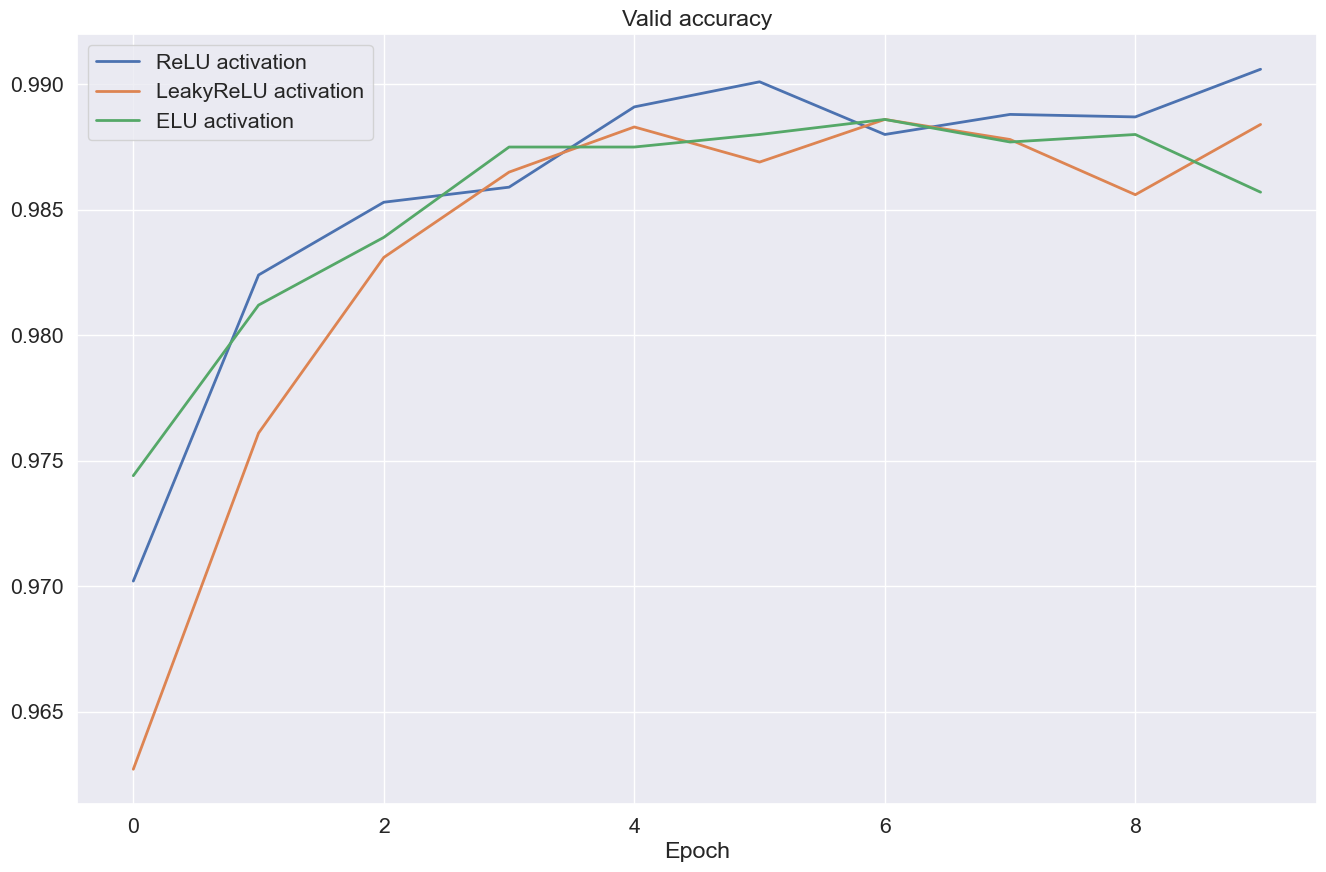

In [84]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy_LeNet, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy_LeNet, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy_LeNet, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** ReLU Accuracy: 0.9906
